In [6]:
import numpy as np
from matplotlib import pyplot as plt
from model import USV
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env

# final_path = np.genfromtxt("data/turtlebot_positions.csv", delimiter=",", skip_header=1)
final_path = np.load("data/first_optimal_path_with_yaw.npy")
# final_path = np.genfromtxt('turtlebot_positions.csv', delimiter=',', skip_header=1)
# final_path = final_path[::10]
final_path = final_path[:,:2]
final_path = final_path*15
# final_path[:,:2]*=15
print(final_path.shape)
print(final_path)
initial_positions = [(final_path[0][0], final_path[0][1], 0)]
# final_path = final_path[:,:2]
# final_path = final_path*15

env = USV(
    v=0,
    dt=0.2,
    path_index=0,
    goal=final_path[-1],
    budget=20,
    initial_positions=initial_positions,
    final_paths=[final_path],
)

model = DQN.load("trained_models/dqn_communication_optimization_meta_400k")
obs, _ = env.reset()
done = False
total_rewards = 0
ep_var = []
# print(env.path_index)
errors = []
# print(errors)
print("-------")
communicate_indices = []
variances = []
car_positions = [[env.car.x_true, env.car.y_true]]
traj_errors=[np.linalg.norm([env.car.x_true, env.car.y_true]-final_path[env.path_index])]
while not done:
    # if env.path_index <= 100:
    #     action = 0
    # else:
    action, _states = model.predict(
        obs[:5], deterministic=True
    )  # Use the model to predict the action
    # action = 1
    # print(f"action: {action}")
    if action == 1:
        communicate_indices.append(env.path_index)

    # print(f"action: {action}")
    # ep_var.append(np.linalg.norm(env.car.pf_var))
    errors.append(
        np.linalg.norm(
            np.array([env.car.x, env.car.y]) - np.array([env.car.x_true, env.car.y_true])
        ))
    variances.append(np.linalg.norm(env.car.pf_var))
    traj_errors.append(np.linalg.norm([env.car.x_true, env.car.y_true]-final_path[env.path_index]))
    obs, rewards, terminated, truncated, info = env.step_test(
        action
    )  # Take the action in the environment
    # print(f"rewards: {rewards}")
    # print(f"info: {info}")
    car_positions.append([env.car.x_true, env.car.y_true])
    total_rewards += rewards
    done = truncated or terminated
    # print(f"obs: {obs}")

(245, 2)
[[-1.34999980e+01  3.75000229e+00]
 [-1.28493327e+01  3.72291413e+00]
 [-1.24759463e+01  3.68811264e+00]
 [-1.21035784e+01  3.64376679e+00]
 [-1.17845057e+01  3.84078827e+00]
 [-1.14622286e+01  4.03252259e+00]
 [-1.11407984e+01  4.22567597e+00]
 [-1.08188418e+01  4.41794816e+00]
 [-1.05132616e+01  4.63531725e+00]
 [-1.02134264e+01  4.86052553e+00]
 [-9.91076451e+00  5.08193438e+00]
 [-9.64045506e+00  5.34185260e+00]
 [-9.36507588e+00  5.59639209e+00]
 [-9.08727054e+00  5.84827655e+00]
 [-8.83738880e+00  6.12789005e+00]
 [-8.58490924e+00  6.40516896e+00]
 [-8.33150271e+00  6.68158955e+00]
 [-8.09232119e+00  6.97041555e+00]
 [-7.85419252e+00  7.26009985e+00]
 [-7.63554170e+00  7.56476446e+00]
 [-7.40225389e+00  7.85836264e+00]
 [-7.17461945e+00  8.15636680e+00]
 [-6.96689774e+00  8.46858451e+00]
 [-6.73553253e+00  8.76369331e+00]
 [-6.53293777e+00  9.07926415e+00]
 [-6.33159042e+00  9.39562463e+00]
 [-6.13173080e+00  9.71292352e+00]
 [-5.92113662e+00  1.00232072e+01]
 [-5.716916

19


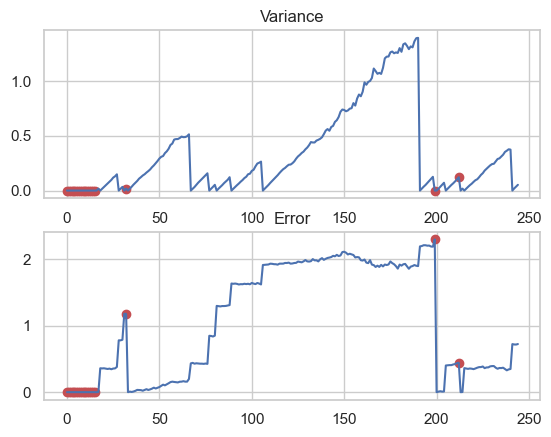

In [7]:
print(len(communicate_indices))
plt.subplot(2, 1, 2)
plt.plot(errors)
plt.scatter(communicate_indices, [errors[i] for i in communicate_indices], c='r')
plt.title("Error")
plt.subplot(2, 1, 1)
plt.plot(variances)
plt.scatter(communicate_indices, [variances[i] for i in communicate_indices], c='r')
plt.title("Variance")
plt.show()

In [8]:
waypoints_followed=0

for i in range(len(traj_errors)):
    if traj_errors[i]<7:
        waypoints_followed+=1
print(waypoints_followed)

print("mean absolute error: ", np.mean(traj_errors))

246
mean absolute error:  0.5447620618657737


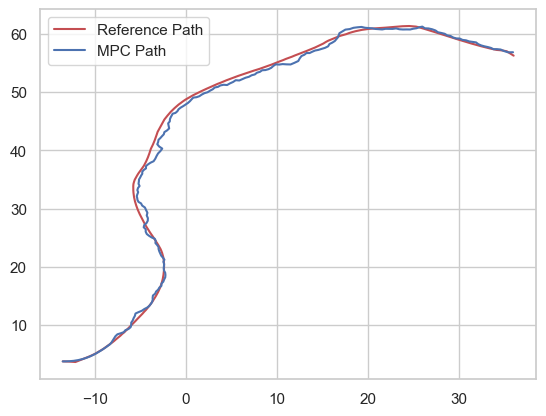

In [9]:
plt.plot(final_path[:, 0], final_path[:, 1], "r", label="Reference Path")
plt.plot(np.array(car_positions)[:, 0], np.array(car_positions)[:, 1], "b", label="MPC Path")
plt.legend()
plt.show()

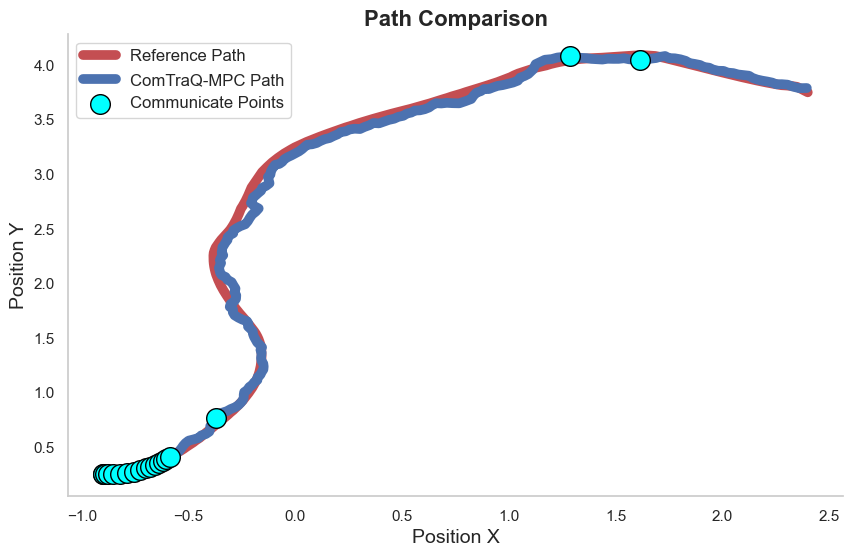

In [10]:
import seaborn as sns
# Set the Seaborn theme
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the reference path
plt.plot(final_path[:, 0]/15, final_path[:, 1]/15, "r-", linewidth=7, label="Reference Path")

# Plot the MPC path
plt.plot(np.array(car_positions)[:, 0]/15, np.array(car_positions)[:, 1]/15, "b-", linewidth=7, label="ComTraQ-MPC Path")

# Highlight communicate points
plt.scatter(np.array(car_positions)[communicate_indices, 0]/15, np.array(car_positions)[communicate_indices, 1]/15, c='cyan', s=200, edgecolor='black', label="Communicate Points", zorder=5)

# If you have a baseline path to plot, uncomment and adjust the following line:
# plt.plot(np.array(car_positions_baseline)[:, 0], np.array(car_positions_baseline)[:, 1], "g-", linewidth=2, label="Baseline Path")

# Add legend with custom font size
plt.legend(fontsize=12)

# Add titles and labels with custom font size for better readability
plt.title("Path Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Position X", fontsize=14)
plt.ylabel("Position Y", fontsize=14)

# Remove the top and right spines for a cleaner look
sns.despine()
plt.grid(False)
plt.show()

In [35]:
np.linalg.norm(final_path[0] - final_path[-1])

57.10432970995237

In [36]:
15*3.8/(15*0.138)

27.53623188405797

In [37]:
82/4

20.5